# Perform a LCOH analysis for an offshore wind + Hydrogen PEM system

### Missing Functionality:
1. Figure out H2A Costs or ammortize cost/kw electrolyzer figure and add opex

~1. Offshore wind site locations and cost details (4 sites, $1300/kw capex + BOS cost which will come from Orbit Runs)~

2. Cost Scaling Based on Year (Have Weiser et. al report with cost scaling for fixed and floating tech, will implement)
3. Cost Scaling Based on Plant Size (Shields et. Al report)
4. Integration Required:
* Pressure Vessel Model~
* HVDC Model 
* Pipeline Model

5. Model Development Required:
- Floating Electrolyzer Platform

### Load necessary modules

In [55]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
import os
import sys
sys.path.append('')
from dotenv import load_dotenv
import pandas as pd
import json
from hybrid.sites import SiteInfo
from hybrid.sites import flatirons_site as sample_site
from hybrid.keys import set_developer_nrel_gov_key
# from plot_reopt_results import plot_reopt_results
# from run_reopt import run_reopt
from examples.H2_Analysis.hopp_for_h2 import hopp_for_h2
from examples.H2_Analysis.run_h2a import run_h2a as run_h2a
from examples.H2_Analysis.simple_dispatch import SimpleDispatch
import examples.H2_Analysis.run_h2_PEM as run_h2_PEM
import numpy as np
import numpy_financial as npf
from lcoe.lcoe import lcoe as lcoe_calc
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set API key
This step gives you access to wind and solar resource data that will be fetched automatically for your desired location.
N.B. If you need an NREL API key, please get one here: https://developer.nrel.gov/signup/

In [56]:
load_dotenv()
NREL_API_KEY = os.getenv("NREL_API_KEY")
set_developer_nrel_gov_key('NREL_API_KEY')  # Set this key manually here if you are not setting it using the .env

# Step 1: User Inputs for scenario

In [57]:
# save_all_runs = pd.DataFrame()

resource_year = 2013
sample_site['year'] = resource_year
useful_life = 30
critical_load_factor = 1
run_reopt_flag = False
custom_powercurve = True
storage_used = True
battery_can_grid_charge = True
grid_connected_hopp = True
interconnection_size_mw = 100
electrolyzer_size = 50


# which plots to show
plot_power_production = True
plot_battery = True
plot_grid = True
plot_h2 = True
turbine_name = '2020ATB_18MW'

scenario = dict()
kw_continuous = electrolyzer_size * 1000
load = [kw_continuous for x in
        range(0, 8760)]  # * (sin(x) + pi) Set desired/required load profile for plant

scenario_choice = 'Offshore Wind-H2 Analysis'
site_selection = 'Site 1'

#Site lat and lon will be set by data loaded from Orbit runs

atb_year = 2025
ptc_avail = 'no'
itc_avail = 'no'
discount_rate = 0.07
forced_sizes = True
force_electrolyzer_cost = True
forced_wind_size = 100
forced_solar_size = 0
forced_storage_size_mw = 100
forced_storage_size_mwh = 200
forced_electrolyzer_cost = 400

solar_cost_kw = 9999
storage_cost_kw = 250
storage_cost_kwh = 240
debt_equity_split = 60

# Enable Ability to purchase/sell electricity to/from grid. Price Defined in $/kWh
# sell_price = 0.01
# buy_price = 0.01
sell_price = False
buy_price = False

In [58]:
# Define Turbine Characteristics based on user selected turbine.
if turbine_name == '2020ATB_12MW':
    custom_powercurve_path = '2020ATB_NREL_Reference_12MW_214.csv' # https://nrel.github.io/turbine-models/2020ATB_NREL_Reference_12MW_214.html
    tower_height = 136
    rotor_diameter = 214
    turbine_rating_mw = 12
    wind_cost_kw = 1300
elif turbine_name == '2020ATB_15MW':
    custom_powercurve_path = '2020ATB_NREL_Reference_15MW_240.csv' # https://nrel.github.io/turbine-models/2020ATB_NREL_Reference_15MW_240.html
    tower_height = 150
    rotor_diameter = 240
    turbine_rating_mw = 15
    wind_cost_kw =  1300
elif turbine_name == '2020ATB_18MW':
    custom_powercurve_path = '2020ATB_NREL_Reference_18MW_263.csv' # https://nrel.github.io/turbine-models/2020ATB_NREL_Reference_18MW_263.html
    tower_height = 156
    rotor_diameter = 263
    turbine_rating_mw = 18
    wind_cost_kw = 1300
    
scenario['Useful Life'] = useful_life
scenario['Debt Equity'] = debt_equity_split
scenario['PTC Available'] = ptc_avail
scenario['ITC Available'] = itc_avail
scenario['Discount Rate'] = discount_rate
scenario['Tower Height'] = tower_height
scenario['Powercurve File'] = custom_powercurve_path

print("Powercurve Path: ", custom_powercurve_path)

Powercurve Path:  2020ATB_NREL_Reference_18MW_263.csv


# Step 2: Extract Scenario Information from ORBIT Runs

In [59]:
# Load Excel file of scenarios
import pandas as pd
path = ('examples/H2_Analysis/OSW_H2_sites_and_costs.xlsx')
xl = pd.ExcelFile(path)
print(xl.sheet_names)
scenario_df = xl.parse('Sheet1')
scenario_df.set_index(["Parameter"], inplace = True)

site_df = scenario_df[site_selection]
# print(site_df)
scenario_df

['Sheet1']


,Site 1,Site 2,Site 3,Site 4,Notes
Parameter,,,,,
Representative region,Gulf of Mexico (west portion of Call Area),Central Atlantic (Call Area E),New York Bight (Bright Wind Holdings Lease),California (Humboldt Lease Area),NaN
Representative coordinates,"27.18624, -96.9516","37.48358, -73.72925","39.53852, -73.1956","40.95078, -124.63619",Just in case we want to pull wind resource dat...
Substructure technology,Fixed - Monopile,Floating - semisubmersible,Fixed - Monopile,Floating - semisubmersible,Jackets could be the preferred fixed technolog...
Plant capacity,996 MW,996 MW,996 MW,996 MW,83 turbines
Turbine rating,12 MW,12 MW,12 MW,12 MW,NaN
Turbine layout,7D x 7D square grid,7D x 7D square grid,7D x 7D square grid,7D x 7D square grid,simplistic
Approx. water depth,45 m,2000 m,40 m,850 m,NaN
Approx. distance to port,80 km,110 km,100 km,55 km,NaN
Approx. distance to export cable landfall,85 km,110 km,80 km,45 km,NaN


### Assign Orbit results to scenario cost details

In [60]:
total_capex = site_df['Total CapEx']
wind_cost_kw = total_capex
site_name = site_df['Representative region']
fixed_or_floating_wind = site_df['Substructure technology']
latlon = site_df['Representative coordinates']
lat, lon = (latlon.split(','))
lat = float(lat)
lon = float(lon)
sample_site['lat'] = lat
sample_site['lon'] = lon
site = SiteInfo(sample_site, hub_height=tower_height)

### Plot Wind Data to ensure offshore data is sound

Text(0.5, 1.0, 'Wind Speed (m/s) for selected location \n Gulf of Mexico (west portion of Call Area) \n lat, lon: 27.18624, -96.9516 \n Average Wind Speed (m/s) 8.367381278538813')

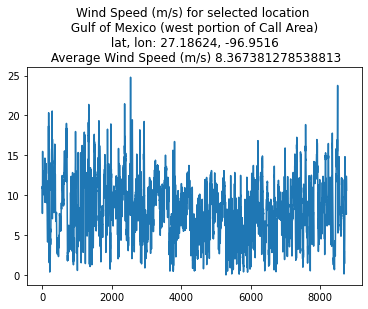

In [61]:
wind_data = site.wind_resource._data['data']
# print(wind_data)

# TODO: Plot and print wind speeds to confirm offshore wind data is sound
wind_speed = [x[2] for x in wind_data]
plt.plot(wind_speed)
plt.title('Wind Speed (m/s) for selected location \n {} \n lat, lon: {} \n Average Wind Speed (m/s) {}'.format(site_name,latlon,np.average(wind_speed)))

### Plot Wind Cost Contributions

ORBIT Cost Contributions for Gulf of Mexico (west portion of Call Area)


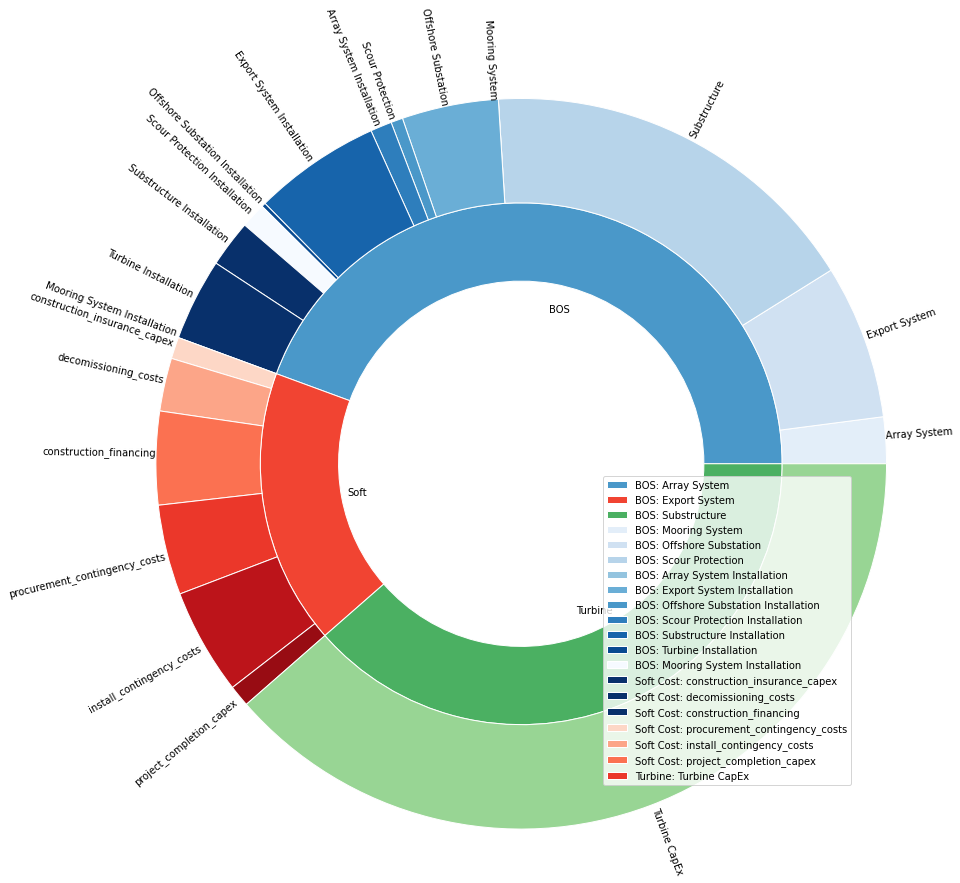

In [62]:
# Plot a nested pie chart of results
group_names=['BOS', 'Soft', 'Turbine']
group_size=[site_df['BOS'],site_df['Soft'],site_df['Turbine CapEx']]
subgroup_names=['Array System','Export System','Substructure','Mooring System',
               'Offshore Substation','Scour Protection','Array System Installation',
               'Export System Installation', 'Offshore Substation Installation',
               'Scour Protection Installation', 'Substructure Installation','Turbine Installation',
               'Mooring System Installation',
               'construction_insurance_capex', 'decomissioning_costs',
               'construction_financing', 'procurement_contingency_costs',
               'install_contingency_costs', 'project_completion_capex',
                'Turbine CapEx']

subgroup_vals = site_df[subgroup_names]
subgroup_size=[x for x in subgroup_vals]

bos_names = ['BOS: '+name for name in subgroup_names[:13]]
soft_names = ['Soft Cost: ' +name for name in subgroup_names[13:-1]]
turbine_names = ['Turbine: '+name for name in subgroup_names[19:]]
all_names = (bos_names + soft_names + turbine_names)
subgroup_names_legs=[x for x in all_names]

# Create colors
a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]

# First Ring (Inside)
fig, ax = plt.subplots(figsize=(12,12))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1, labels=group_names, labeldistance=.6, colors= 
[a(0.6), b(0.6), c(0.6)] )
plt.setp( mypie, width=0.3, edgecolor='white')

# Second Ring (Outside)
mypie2, _ = ax.pie(subgroup_size, radius=1.0+0.4, 
labels=subgroup_names, labeldistance=1, rotatelabels=True, colors=[a(0.1), a(0.2), 
a(0.3), a(0.4), a(0.5), a(0.6), a(0.7), a(0.8), a(0.9), a(1), a(1.1), a(1.2),
                                                 a(1.3),b(.16),b(.32),b(.48),b(.64),b(.8),b(.9),c(.4)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

plt.legend(loc=(0.9, 0.1))
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[3:], subgroup_names_legs, loc=(0.4, 0.3))

plt.legend(subgroup_names_legs,loc='best')
# plt.title('ORBIT Cost Contributions for {}'.format(site_name))
print('ORBIT Cost Contributions for {}'.format(site_name))
plt.show()

### Display Future Cost Reduction Estimates



In [63]:
# Floating Wind Cost Reductions
parent_path = os.path.abspath('')
floating_cost_reductions_df = pd.read_csv(os.path.join(parent_path,'examples/H2_Analysis/floating_cost_reductions.csv'))

# Fixed Wind Cost Reductions
fixed_cost_reductions_df = pd.read_csv(os.path.join(parent_path,'examples/H2_Analysis/fixed_cost_reductions.csv'))

if fixed_or_floating_wind == 'Fixed - Monopile':
    capex_reduction = fixed_cost_reductions_df[str(atb_year)][0]
    opex_reduction = fixed_cost_reductions_df[str(atb_year)][1]
    net_cf_increase = fixed_cost_reductions_df[str(atb_year)][2]
elif fixed_or_floating_wind == 'Floating - semisubmersible':
    capex_reduction = floating_cost_reductions_df[str(atb_year)][0]
    opex_reduction = floating_cost_reductions_df[str(atb_year)][1]
    net_cf_increase = floating_cost_reductions_df[str(atb_year)][2]

print("For {} wind in {}, capex reduction is estimated to be: {}, opex reduction is: {}, and net capacity factor increase is: {}.".format(fixed_or_floating_wind, str(atb_year), capex_reduction, opex_reduction, net_cf_increase))

For Fixed - Monopile wind in 2025, capex reduction is estimated to be: 11.50%, opex reduction is: 8.25%, and net capacity factor increase is: 2.63%.


### Display Turbine and Plant Cost Scaling Estimates

##### Estimates From: "Impacts of turbine and plant upsizing on the levelized cost of energy for offshore wind" -  Shields et. Al 2021

In [64]:
# Inputs: Turbine Rating and Design, Plant Capacity, Plant Layout.

# Step 3: Run HOPP

In [65]:
if forced_sizes:
    solar_size_mw = forced_solar_size
    wind_size_mw = forced_wind_size
    storage_size_mw = forced_storage_size_mw
    storage_size_mwh = forced_storage_size_mwh
    storage_hours = 0

if storage_size_mw > 0:
    technologies = {'pv':
                        {'system_capacity_kw': solar_size_mw * 1000},
                    'wind':
                        {'num_turbines': np.floor(wind_size_mw / turbine_rating_mw),
                            'turbine_rating_kw': turbine_rating_mw*1000,
                            'hub_height': tower_height,
                            'rotor_diameter': rotor_diameter},
                    'battery': {
                        'system_capacity_kwh': storage_size_mwh * 1000,
                        'system_capacity_kw': storage_size_mw * 1000
                        }
                    }
else:
            technologies = {'pv':
                        {'system_capacity_kw': solar_size_mw * 1000},
                    'wind':
                        {'num_turbines': np.floor(wind_size_mw / turbine_rating_mw),
                            'turbine_rating_kw': turbine_rating_mw*1000,
                            'hub_height': tower_height,
                            'rotor_diameter': rotor_diameter},
    #                 'battery': {
    #                     'system_capacity_kwh': storage_size_mwh * 1000,
    #                     'system_capacity_kw': storage_size_mw * 1000
    #                     }
                    }

hybrid_plant, combined_pv_wind_power_production_hopp, combined_pv_wind_curtailment_hopp,\
energy_shortfall_hopp, annual_energies, wind_plus_solar_npv, npvs, lcoe =  \
    hopp_for_h2(site, scenario, technologies,
                wind_size_mw, solar_size_mw, storage_size_mw, storage_size_mwh, storage_hours,
    wind_cost_kw, solar_cost_kw, storage_cost_kw, storage_cost_kwh,
    kw_continuous, load,
    custom_powercurve,
    electrolyzer_size, grid_connected_hopp=True)

wind_installed_cost = hybrid_plant.wind.total_installed_cost
solar_installed_cost = hybrid_plant.pv.total_installed_cost
hybrid_installed_cost = hybrid_plant.grid.total_installed_cost
print("HOPP run complete")

HOPP run complete


# Step 4: Plot HOPP Results

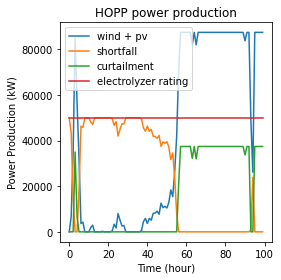

Turbine Power Output (to identify powercurve impact): 375,509,919 kW


In [66]:
if plot_power_production:
    plt.figure(figsize=(4,4))
    plt.title("HOPP power production")
    plt.plot(combined_pv_wind_power_production_hopp[200:300],label="wind + pv")
    plt.plot(energy_shortfall_hopp[200:300],label="shortfall")
    plt.plot(combined_pv_wind_curtailment_hopp[200:300],label="curtailment")
    plt.plot(load[200:300],label="electrolyzer rating")
    plt.xlabel("Time (hour)")
    plt.ylabel("Power Production (kW)")
    # plt.ylim(0,250000)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("Turbine Power Output (to identify powercurve impact): {0:,.0f} kW".format(hybrid_plant.wind.annual_energy_kw))

# Step 5: Run Simple Dispatch Model


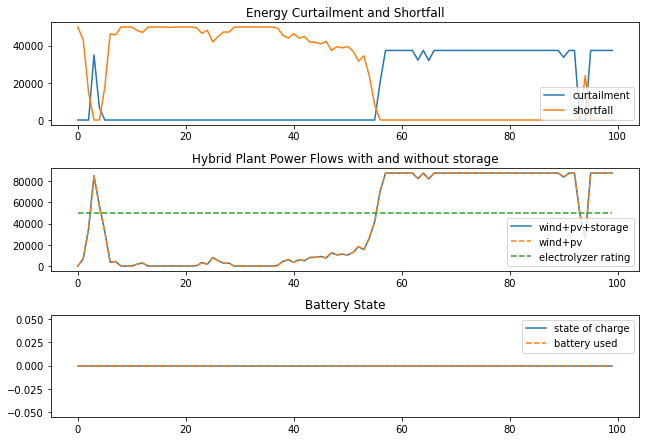

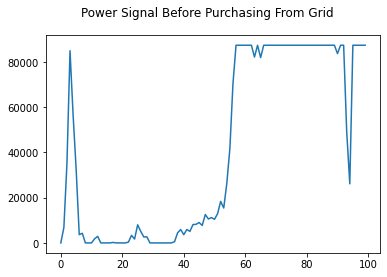

In [67]:
bat_model = SimpleDispatch()
bat_model.Nt = len(energy_shortfall_hopp)
bat_model.curtailment = combined_pv_wind_curtailment_hopp
bat_model.shortfall = energy_shortfall_hopp
# print(combined_pv_wind_curtailment_hopp)
# print(energy_shortfall_hopp)

# bat_model.battery_storage = 100 * 1000
# bat_model.charge_rate = 100 * 1000
# bat_model.discharge_rate = 100 * 1000

battery_used, excess_energy, battery_SOC = bat_model.run()
combined_pv_wind_storage_power_production_hopp = combined_pv_wind_power_production_hopp + battery_used

if plot_battery:
    plt.figure(figsize=(9,6))
    plt.subplot(311)
    plt.plot(combined_pv_wind_curtailment_hopp[200:300],label="curtailment")
    plt.plot(energy_shortfall_hopp[200:300],label="shortfall")
    plt.title('Energy Curtailment and Shortfall')
    plt.legend()
    

    plt.subplot(312)
    plt.plot(combined_pv_wind_storage_power_production_hopp[200:300],label="wind+pv+storage")
    plt.plot(combined_pv_wind_power_production_hopp[200:300],"--",label="wind+pv")
    plt.plot(load[200:300],"--",label="electrolyzer rating")
    plt.legend()
    plt.title("Hybrid Plant Power Flows with and without storage")
    plt.tight_layout()
    
    plt.subplot(313)
    plt.plot(battery_SOC[200:300],label="state of charge")
    plt.plot(battery_used[200:300],"--",label="battery used")
    plt.title('Battery State')
    plt.legend()
    plt.show()

if plot_grid:
    plt.plot(combined_pv_wind_storage_power_production_hopp[200:300],label="before buy from grid")
    plt.suptitle("Power Signal Before Purchasing From Grid")

if sell_price:
    profit_from_selling_to_grid = np.sum(excess_energy)*sell_price
else:
    profit_from_selling_to_grid = 0.0

# buy_price = False # if you want to force no buy from grid
if buy_price:
    cost_to_buy_from_grid = 0.0

    for i in range(len(combined_pv_wind_storage_power_production_hopp)):
        if combined_pv_wind_storage_power_production_hopp[i] < kw_continuous:
            cost_to_buy_from_grid += (kw_continuous-combined_pv_wind_storage_power_production_hopp[i])*buy_price
            combined_pv_wind_storage_power_production_hopp[i] = kw_continuous
else:
    cost_to_buy_from_grid = 0.0

energy_to_electrolyzer = [x if x < kw_continuous else kw_continuous for x in combined_pv_wind_storage_power_production_hopp]




### Plot Dispatch Results

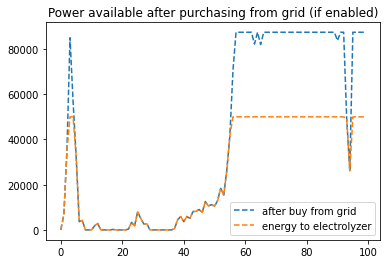

In [68]:

if plot_grid:
    plt.plot(combined_pv_wind_storage_power_production_hopp[200:300],"--",label="after buy from grid")
    plt.plot(energy_to_electrolyzer[200:300],"--",label="energy to electrolyzer")
    plt.legend()
    plt.title('Power available after purchasing from grid (if enabled)')
    plt.show()



# Step 6: Run the H2_PEM model

Total power input to electrolyzer: 273352598.7226277
Hydrogen Annual Output (kg): 4761073.334025189
Water Consumption (kg) Total: 47610733.34025254


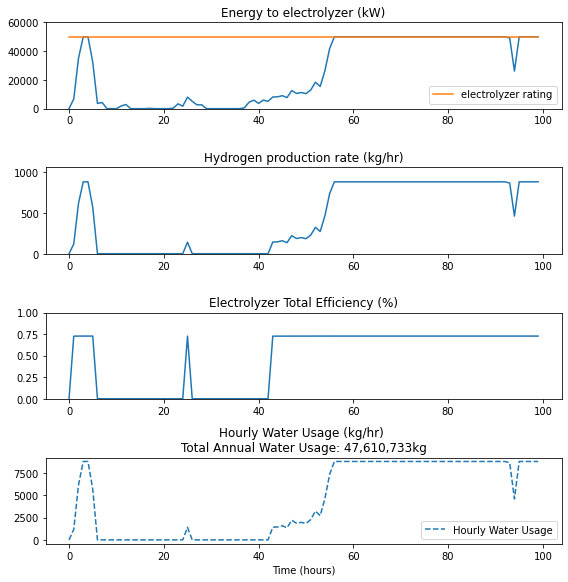

In [69]:
#TODO: Refactor H2A model call
# Should take as input (electrolyzer size, cost, electrical timeseries, total system electrical usage (kwh/kg),
# Should give as ouptut (h2 costs by net cap cost, levelized, total_unit_cost of hydrogen etc)   )

# electrical_generation_timeseries = combined_pv_wind_storage_power_production_hopp
electrical_generation_timeseries = np.zeros_like(energy_to_electrolyzer)
electrical_generation_timeseries[:] = energy_to_electrolyzer[:]

adjusted_installed_cost = hybrid_plant.grid._financial_model.Outputs.adjusted_installed_cost
#NB: adjusted_installed_cost does NOT include the electrolyzer cost
useful_life = scenario['Useful Life']
net_capital_costs = 0

# system_rating = electrolyzer_size
system_rating = wind_size_mw + solar_size_mw
H2_Results, H2A_Results = run_h2_PEM.run_h2_PEM(electrical_generation_timeseries,electrolyzer_size,
                kw_continuous,forced_electrolyzer_cost,lcoe,adjusted_installed_cost,useful_life,
                net_capital_costs)


H2_Results['hydrogen_annual_output'] = H2_Results['hydrogen_annual_output']

print("Total power input to electrolyzer: {}".format(np.sum(electrical_generation_timeseries)))
print("Hydrogen Annual Output (kg): {}".format(H2_Results['hydrogen_annual_output']))
print("Water Consumption (kg) Total: {}".format(H2_Results['water_annual_usage']))

if plot_h2:
    hydrogen_hourly_production = H2_Results['hydrogen_hourly_production']
    plt.figure(figsize=(8,8))
    plt.subplot(411)
    plt.plot(electrical_generation_timeseries[200:300])
    plt.ylim(0,max(electrical_generation_timeseries[200:300])*1.2)
    plt.plot(load[200:300],label="electrolyzer rating")
    plt.legend()
    plt.title("Energy to electrolyzer (kW)")

    plt.subplot(412)
    plt.plot(hydrogen_hourly_production[200:300])
    plt.ylim(0,max(hydrogen_hourly_production[200:300])*1.2)
    plt.title("Hydrogen production rate (kg/hr)")

    
    plt.subplot(413)
    plt.plot(H2_Results['electrolyzer_total_efficiency'][200:300])
    plt.ylim(0,1)
    plt.title("Electrolyzer Total Efficiency (%)")
    
    
    plt.subplot(414)
    plt.plot(H2_Results['water_hourly_usage'][200:300],"--",label="Hourly Water Usage")
    plt.legend()
    plt.title('Hourly Water Usage (kg/hr) \n' 'Total Annual Water Usage: {0:,.0f}kg'.format(H2_Results['water_annual_usage']))
    plt.tight_layout()
    plt.xlabel('Time (hours)')
    plt.show()

# Step 6b: Run desal model

Max power allowed by system:  26.37837837837838 kW
For 50MW Electrolyzer, implementing 9.00900900900901m^3/hr desal system
Estimated constant desal power usage 0.026MW
Desal System CAPEX ($): 82,070.37
Desal System OPEX ($): 12,078.27
Total Annual Feedwater Required (m^3): 145,780.19


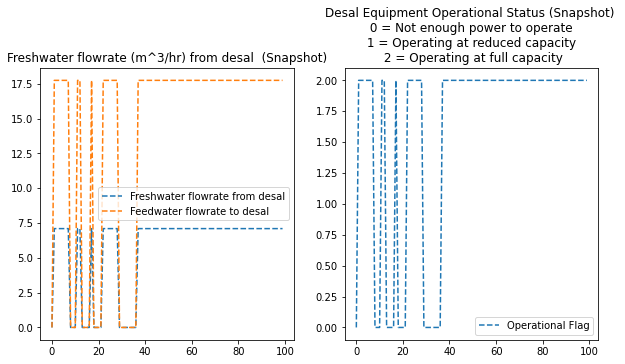

In [74]:
from examples.H2_Analysis.desal_model import RO_desal

water_usage_electrolyzer = H2_Results['water_hourly_usage']
m3_water_per_kg_h2 = 0.01
desal_system_size_m3_hr = electrolyzer_size * (1000/55.5) * m3_water_per_kg_h2
est_const_desal_power_mw_hr = desal_system_size_m3_hr * 2.928 /1000 # 4kWh/m^3 desal efficiency estimate
# Power = [(est_const_desal_power_mw_hr) * 1000 for x in range(0, 8760)]
Power = electrical_generation_timeseries
fresh_water_flowrate, feed_water_flowrate, operational_flags, desal_capex, desal_opex, desal_annuals = RO_desal(Power, desal_system_size_m3_hr, useful_life)
print("For {}MW Electrolyzer, implementing {}m^3/hr desal system".format(electrolyzer_size, desal_system_size_m3_hr))
print("Estimated constant desal power usage {0:.3f}MW".format(est_const_desal_power_mw_hr))
print("Desal System CAPEX ($): {0:,.02f}".format(desal_capex))
print("Desal System OPEX ($): {0:,.02f}".format(desal_opex))
# print("Freshwater Flowrate (m^3/hr): {}".format(fresh_water_flowrate))
print("Total Annual Feedwater Required (m^3): {0:,.02f}".format(np.sum(feed_water_flowrate)))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(fresh_water_flowrate[200:300],"--",label="Freshwater flowrate from desal")
plt.plot(feed_water_flowrate[200:300],"--",label="Feedwater flowrate to desal")
plt.legend()
plt.title('Freshwater flowrate (m^3/hr) from desal  (Snapshot)')
# plt.show()

plt.subplot(1,2,2)
plt.plot(operational_flags[200:300],"--",label="Operational Flag")
plt.legend()
plt.title('Desal Equipment Operational Status (Snapshot) \n 0 = Not enough power to operate \n 1 = Operating at reduced capacity \n 2 = Operating at full capacity')
plt.show()

## Static Pressure Vessel Model Example

In [ ]:
from examples.H2_Analysis.pressure_vessel_model import static_pressure_vessel
storage_volume, compressor_work, pressure_vessel_capex, pressure_vessel_opex = static_pressure_vessel(H2_storage = True)

# Step 6.5: Intermediate financial calculation

In [78]:
total_elec_production = np.sum(electrical_generation_timeseries)
total_hopp_installed_cost = hybrid_plant.grid._financial_model.SystemCosts.total_installed_cost
total_electrolyzer_cost = H2A_Results['scaled_total_installed_cost']
print(H2A_Results['scaled_total_installed_cost_kw'])
total_system_installed_cost = total_hopp_installed_cost + total_electrolyzer_cost
annual_operating_cost_h2 = H2A_Results['Fixed O&M'] * H2_Results['hydrogen_annual_output']
annual_operating_cost_desal = desal_opex
total_annual_operating_costs =  annual_operating_cost_h2 + annual_operating_cost_desal + cost_to_buy_from_grid - profit_from_selling_to_grid

# h_lcoe_no_op_cost = lcoe_calc((H2_Results['hydrogen_annual_output']), total_system_installed_cost,
#                    0, 0.07, useful_life)

h_lcoe = lcoe_calc((H2_Results['hydrogen_annual_output']), total_system_installed_cost,
                    total_annual_operating_costs, discount_rate, useful_life)

# Cashflow Financial Calculation
discount_rate = scenario['Discount Rate']
cf_wind_annuals = hybrid_plant.wind._financial_model.Outputs.cf_annual_costs
if solar_size_mw > 0:
    cf_solar_annuals = hybrid_plant.pv._financial_model.Outputs.cf_annual_costs
else:
    cf_solar_annuals = np.zeros(30)
cf_h2_annuals = H2A_Results['expenses_annual_cashflow'] # This might be unreliable. 
cf_operational_annuals = [-total_annual_operating_costs for i in range(30)]

cf_df = pd.DataFrame([cf_wind_annuals, cf_solar_annuals, cf_h2_annuals[:len(cf_wind_annuals)]],['Wind', 'Solar', 'H2'])
results_dir = parent_path + '/examples/H2_Analysis/results/'
cf_df.to_csv(os.path.join(results_dir, "Annual Cashflows_{}_{}_{}_discount_{}.csv".format(site_name, scenario_choice, atb_year, discount_rate)))

#NPVs of wind, solar, H2
npv_wind_costs = npf.npv(discount_rate, cf_wind_annuals)
npv_solar_costs = npf.npv(discount_rate, cf_solar_annuals)
npv_h2_costs = npf.npv(discount_rate, cf_h2_annuals)
npv_operating_costs = npf.npv(discount_rate, cf_operational_annuals)
npv_desal_costs = desal_capex
npv_total_costs = npv_wind_costs+npv_solar_costs+npv_h2_costs
npv_total_costs_w_operating_costs = npv_wind_costs+npv_solar_costs+npv_h2_costs+npv_operating_costs


LCOH_cf_method_wind = -npv_wind_costs / (H2_Results['hydrogen_annual_output'] * useful_life)
LCOH_cf_method_solar = -npv_solar_costs / (H2_Results['hydrogen_annual_output'] * useful_life)
LCOH_cf_method_h2_costs = -npv_h2_costs / (H2_Results['hydrogen_annual_output'] * useful_life)
LCOH_cf_method_desal_costs = npv_desal_costs / (H2_Results['hydrogen_annual_output'] * useful_life)
LCOH_cf_method_operating_costs = -npv_operating_costs / (H2_Results['hydrogen_annual_output'] * useful_life)

LCOH_cf_method = -npv_total_costs / (H2_Results['hydrogen_annual_output'] * useful_life)
LCOH_cf_method_w_operating_costs = -npv_total_costs_w_operating_costs / (H2_Results['hydrogen_annual_output'] * useful_life)
financial_summary_df = pd.DataFrame([scenario['Useful Life'], wind_cost_kw, solar_cost_kw, forced_electrolyzer_cost,
                                        scenario['Debt Equity'], atb_year, ptc_avail, itc_avail,
                                        discount_rate, npv_wind_costs, npv_solar_costs, npv_h2_costs, LCOH_cf_method],
                                    ['Useful Life', 'Wind Cost KW', 'Solar Cost KW', 'Electrolyzer Cost KW', 'Debt Equity',
                                        'ATB Year', 'PTC available', 'ITC available', 'Discount Rate', 'NPV Wind Expenses', 'NPV Solar Expenses', 'NPV H2 Expenses', 'LCOH cf method'])
financial_summary_df.to_csv(os.path.join(results_dir, 'Financial Summary.csv'))

# Gut Check H2 calculation (non-levelized)
total_installed_and_operational_lifetime_cost = total_system_installed_cost + (30 * total_annual_operating_costs)
lifetime_h2_production = 30 * H2_Results['hydrogen_annual_output']
gut_check_h2_cost_kg = total_installed_and_operational_lifetime_cost / lifetime_h2_production

print("Gut Check H2 Cost:",gut_check_h2_cost_kg)
print("LCOH w/o Operating Cost for H2, Desal, Pressure Vessel, Grid Electrical Cost:", LCOH_cf_method)
print("LCOH WITH Operating Cost for H2, Desal, Pressure Vessel, Grid Electrical Cost:", LCOH_cf_method_w_operating_costs)

313.9875419356345
Gut Check H2 Cost: 3.6405206807494053
LCOH w/o Operating Cost for H2, Desal, Pressure Vessel, Grid Electrical Cost: 3.7800701276264133
LCOH WITH Operating Cost for H2, Desal, Pressure Vessel, Grid Electrical Cost: 3.987226805756694


# Step 7: Plot Results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = [site_name]
  
# plot bars in stack manner
plt.bar(x, LCOH_cf_method_wind, color='blue')
plt.bar(x, LCOH_cf_method_solar, bottom=LCOH_cf_method_wind, color='orange')
plt.bar(x, LCOH_cf_method_h2_costs, bottom =LCOH_cf_method_wind + LCOH_cf_method_solar, color='g')
plt.bar(x, LCOH_cf_method_operating_costs, bottom=LCOH_cf_method_wind + LCOH_cf_method_solar + LCOH_cf_method_h2_costs, color='y')
plt.bar(x, LCOH_cf_method_desal_costs, bottom=LCOH_cf_method_wind + LCOH_cf_method_solar + LCOH_cf_method_h2_costs + LCOH_cf_method_operating_costs, color='k')

plt.ylabel("LCOH")
plt.legend(["Wind", "Solar", "H2", "Operating Costs", "Desal"])
plt.title("Levelized Cost of hydrogen - Cost Contributors")
plt.show()
a= 'white'

plt.show()

# Step 8: Print  Results

In [ ]:
print_results = False
print_h2_results = True

if print_results:
    # ------------------------- #
    #TODO: Tidy up these print statements
    print("Future Scenario: {}".format(scenario['Scenario Name']))
    print("Wind Cost per KW: {}".format(scenario['Wind Cost KW']))
    print("PV Cost per KW: {}".format(scenario['Solar Cost KW']))
    print("Storage Cost per KW: {}".format(scenario['Storage Cost kW']))
    print("Storage Cost per KWh: {}".format(scenario['Storage Cost kWh']))
    print("Wind Size built: {}".format(wind_size_mw))
    print("PV Size built: {}".format(solar_size_mw))
    print("Storage Size built: {}".format(storage_size_mw))
    print("Storage Size built: {}".format(storage_size_mwh))
    print("Levelized cost of Electricity (HOPP): {}".format(lcoe))
    print("Total Yearly Electrical Output: {}".format(total_elec_production))
    print("Total Yearly Hydrogen Production: {}".format(H2_Results['hydrogen_annual_output']))
    print("Levelized Cost H2/kg (new method - no operational costs)".format(h_lcoe_no_op_cost))
    print("Capacity Factor of Electrolyzer: {}".format(H2_Results['cap_factor']))

if print_h2_results:
    print('Total Lifetime H2(kg) produced: {}'.format(lifetime_h2_production))
    print("Gut-check H2 cost/kg: {}".format(gut_check_h2_cost_kg))
#     print("h_lcoe: ", h_lcoe)
    print("LCOH CF Method (doesn't include grid electricity cost if used)", LCOH_cf_method)
    print("LCOH CF Method (includes operating costs + electricity)", LCOH_cf_method_w_operating_costs)
    # print("Levelized cost of H2 (electricity feedstock) (HOPP): {}".format(
    #     H2_Results['feedstock_cost_h2_levelized_hopp']))
    # print("Levelized cost of H2 (excl. electricity) (H2A): {}".format(H2A_Results['Total Hydrogen Cost ($/kgH2)']))
    # print("Total unit cost of H2 ($/kg) : {}".format(H2_Results['total_unit_cost_of_hydrogen']))
    # print("kg H2 cost from net cap cost/lifetime h2 production (HOPP): {}".format(
    #     H2_Results['feedstock_cost_h2_via_net_cap_cost_lifetime_h2_hopp']))

# Step 9: Summarize Results

In [ ]:
print('For a {}MW Offshore Wind Plant with {}MW electrolyzer located at {} \n (average wind speed {}m/s) in {}, with a Wind CAPEX cost of {},\n and an Electrolyzer cost of {}$/kW:\n The levelized cost of hydrogen was {} /kg '.
               format(forced_wind_size,electrolyzer_size,site_name,np.average(wind_speed),atb_year,site_df['Total CapEx'],forced_electrolyzer_cost,LCOH_cf_method_w_operating_costs))

print("LCOH CF Method (doesn't include grid electricity cost if used)", LCOH_cf_method)
print("LCOH CF Method (includes operating costs + electricity)", LCOH_cf_method_w_operating_costs)

# Step 10: Save Results

### Create output dictionary

In [ ]:
def establish_save_output_dict():
    """
    Establishes and returns a 'save_outputs_dict' dict
    for saving the relevant analysis variables for each site.
    """

    save_outputs_dict = dict()
    save_outputs_dict['Site Name'] = list()
    save_outputs_dict['Scenario Choice'] = list()
    save_outputs_dict['Site Lat'] = list()
    save_outputs_dict['Site Lon'] = list()
    save_outputs_dict['ATB Year'] = list()
    save_outputs_dict['Resource Year'] = list()
    save_outputs_dict['Critical Load Factor'] = list()
    save_outputs_dict['kW continuous load'] = list()
    save_outputs_dict['Useful Life'] = list()
    save_outputs_dict['PTC'] = list()
    save_outputs_dict['ITC'] = list()
    save_outputs_dict['Discount Rate'] = list()
    save_outputs_dict['Debt Equity'] = list()
    save_outputs_dict['Hub Height (m)'] = list()
    save_outputs_dict['Storage Enabled'] = list()
    save_outputs_dict['Wind Cost kW'] = list()
    save_outputs_dict['Solar Cost kW'] = list()
    save_outputs_dict['Storage Cost kW'] = list()
    save_outputs_dict['Storage Cost kWh'] = list()
    save_outputs_dict['Storage Hours'] = list()
    save_outputs_dict['Wind MW built'] = list()
    save_outputs_dict['Solar MW built'] = list()
    save_outputs_dict['Storage MW built'] = list()
    save_outputs_dict['Storage MWh built'] = list()
    save_outputs_dict['Electrolyzer Size'] = list()
    save_outputs_dict['Electrolyzer Total System Size'] = list()
    save_outputs_dict['Battery Can Grid Charge'] = list()
    save_outputs_dict['Grid Connected HOPP'] = list()
    save_outputs_dict['Built Interconnection Size'] = list()
    save_outputs_dict['Total Installed Cost $(HOPP)'] = list()
    save_outputs_dict['Total Yearly Electrical Output'] = list()
    save_outputs_dict['LCOE'] = list()
    save_outputs_dict['Total Annual H2 production (kg)'] = list()
    save_outputs_dict['Gut-Check Cost/kg H2 (non-levelized, includes elec if used)'] = list()
    save_outputs_dict['Levelized Cost/kg H2 (lcoe using installed and operation costs)'] = list()
    save_outputs_dict['Levelized Cost/kg H2 (CF Method - using annual cashflows per technology)'] = list()
    save_outputs_dict['H2A scaled total install cost'] = list()
    save_outputs_dict['H2A scaled total install cost per kw'] = list()
    save_outputs_dict['HOPP Total Generation'] = list()
    save_outputs_dict['Wind Capacity Factor'] = list()
    save_outputs_dict['HOPP Energy Shortfall'] = list()
    save_outputs_dict['HOPP Curtailment'] = list()
    save_outputs_dict['Battery Generation'] = list()
    save_outputs_dict['Electricity to Grid'] = list()
    
    return save_outputs_dict

In [ ]:
save_outputs_dict = establish_save_output_dict()

In [ ]:
# Step 9: Plot HOPP Production, Curtailment, and Hydrogen Production Profiles
# ------------------------- #
#TODO: Place in function

save_outputs_dict['Site Name'].append(site_name)
save_outputs_dict['Scenario Choice'].append(scenario_choice)
save_outputs_dict['Site Lat'].append(lat)
save_outputs_dict['Site Lon'].append(lon)
save_outputs_dict['ATB Year'].append(atb_year)
save_outputs_dict['Resource Year'].append(resource_year)
save_outputs_dict['Critical Load Factor'].append(critical_load_factor)
save_outputs_dict['kW continuous load'].append(kw_continuous)
save_outputs_dict['Useful Life'].append(useful_life)
save_outputs_dict['PTC'].append(ptc_avail)
save_outputs_dict['ITC'].append(itc_avail)
save_outputs_dict['Discount Rate'].append(discount_rate)
save_outputs_dict['Debt Equity'].append(debt_equity_split)
save_outputs_dict['Hub Height (m)'].append(tower_height)
save_outputs_dict['Storage Enabled'].append(storage_used)
save_outputs_dict['Wind Cost kW'].append(wind_cost_kw)
save_outputs_dict['Solar Cost kW'].append(solar_cost_kw)
save_outputs_dict['Storage Cost kW'].append(storage_cost_kw)
save_outputs_dict['Storage Cost kWh'].append(storage_cost_kwh)
save_outputs_dict['Storage Hours'].append(storage_hours)
save_outputs_dict['Wind MW built'].append(wind_size_mw)
save_outputs_dict['Solar MW built'].append(solar_size_mw)
save_outputs_dict['Storage MW built'].append(storage_size_mw)
save_outputs_dict['Storage MWh built'].append(storage_size_mwh)
save_outputs_dict['Battery Can Grid Charge'].append(battery_can_grid_charge)
save_outputs_dict['Built Interconnection Size'].append(hybrid_plant.interconnect_kw)
save_outputs_dict['Total Installed Cost $(HOPP)'].append(total_hopp_installed_cost)
save_outputs_dict['Total Yearly Electrical Output'].append(total_elec_production)
save_outputs_dict['LCOE'].append(lcoe)
save_outputs_dict['Total Annual H2 production (kg)'].append(H2_Results['hydrogen_annual_output'])
save_outputs_dict['Gut-Check Cost/kg H2 (non-levelized, includes elec if used)'].append(gut_check_h2_cost_kg)
save_outputs_dict['Levelized Cost/kg H2 (lcoe using installed and operation costs)'].append(h_lcoe)
save_outputs_dict['Levelized Cost/kg H2 (CF Method - using annual cashflows per technology)'].append(LCOH_cf_method)
save_outputs_dict['Grid Connected HOPP'].append(grid_connected_hopp)
save_outputs_dict['HOPP Total Generation'].append(np.sum(hybrid_plant.grid.generation_profile[0:8759]))
save_outputs_dict['Wind Capacity Factor'].append(hybrid_plant.wind._system_model.Outputs.capacity_factor)
save_outputs_dict['HOPP Energy Shortfall'].append(np.sum(energy_shortfall_hopp))
save_outputs_dict['HOPP Curtailment'].append(np.sum(combined_pv_wind_curtailment_hopp))
save_outputs_dict['Battery Generation'].append(np.sum(battery_used))
save_outputs_dict['Electricity to Grid'].append(np.sum(excess_energy))
save_outputs_dict['Electrolyzer Size'].append(H2A_Results['electrolyzer_size'])
save_outputs_dict['Electrolyzer Total System Size'].append(H2A_Results['total_plant_size'])
save_outputs_dict['H2A scaled total install cost'].append(H2A_Results['scaled_total_installed_cost'])
save_outputs_dict['H2A scaled total install cost per kw'].append(H2A_Results['scaled_total_installed_cost_kw'])


# save_all_runs = save_all_runs.append(save_outputs_dict, sort=False)
# Create dataframe from outputs and save
save_outputs = True
if save_outputs:
    save_outputs_dict_df = pd.DataFrame(save_outputs_dict)
    save_outputs_dict_df.to_csv(os.path.join(results_dir, "H2_Analysis_{}.csv".format('Main')))
    

# ~~Step 2a: Load scenarios from .csv and enumerate~~

In [ ]:
# # Setting all scenario inputs manuall for now

# # parent_path = os.path.abspath('')
# # print(parent_path)
# # scenarios_df = pd.read_csv(os.path.join(parent_path,'examples/H2_Analysis/osw_h2_scenario.csv'))

# for i, scenario in scenarios_df.iterrows():
#     kw_continuous = electrolyzer_size * 1000
#     load = [kw_continuous for x in
#             range(0, 8760)]  # * (sin(x) + pi) Set desired/required load profile for plant

#     scenario_choice = scenario['Scenario Name']
#     site_name = scenario['Site Name']
#     sample_site['lat'] = scenario['Lat']
#     sample_site['lon'] = scenario['Long']
#     lat = scenario['Lat']
#     lon = scenario['Long']
#     atb_year = scenario['ATB Year']
#     ptc_avail = scenario['PTC Available']
#     itc_avail = scenario['ITC Available']
#     forced_sizes = scenario['Force Plant Size']
#     force_electrolyzer_cost = scenario['Force Electrolyzer Cost']
#     if forced_sizes:
#         forced_wind_size = scenario['Wind Size MW']
#         forced_solar_size = scenario['Solar Size MW']
#         forced_storage_size_mw = scenario['Storage Size MW']
#         forced_storage_size_mwh = scenario['Storage Size MWh']
#     else:
#         print("Using ReOPT for sizing. REopt will be turned on and may not find a solution")
#         run_reopt_flag = True

#     if force_electrolyzer_cost:
#         forced_electrolyzer_cost = scenario['Electrolyzer Cost KW']

#     wind_cost_kw = scenario['Wind Cost KW']
#     solar_cost_kw = scenario['Solar Cost KW']
#     storage_cost_kw = scenario['Storage Cost KW']
#     storage_cost_kwh = scenario['Storage Cost KWh']
#     debt_equity_split = scenario['Debt Equity']

#     buy_price = scenario['Buy From Grid ($/kWh)']
#     sell_price = scenario['Sell To Grid ($/kWh)']

#     #Todo: Add useful life to .csv scenario input instead
#     scenario['Useful Life'] = useful_life

#     site = SiteInfo(sample_site, hub_height=tower_height)
# # scenarios_df